# Extracting regional values from Met Office Global meteorological data

## Process
This notebook runs you through how to extract spatial mean values from gridded data using shapefiles. The process includes:
1. Loading the gridded data from NetCDF files into memory using xarray .
2. Load the Shapefile for the regions we want to subset with.
3. Subsetting, collapsing for each region.
4. Save out to CSV.

## Method
https://regionmask.readthedocs.io

#### Improvements
- weighting the grid cells according to how much of their area is within the polygon?
- performance increase when sublselecting UK area beforehand

# Setup

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#System
import os
import sys
import glob

In [3]:
import xarray as xr
xr.set_options(keep_attrs=True)
import pandas as pd
import regionmask

In [4]:
import cartopy.crs as ccrs

In [5]:
#Supress warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Load Met Office Global Data

The files for each variable are contained in a separate folder.

In [6]:
precip = xr.open_mfdataset('/Users/aaron.spring/Downloads/global_daily_precip_max_2020010?.nc',concat_dim='time').rename({'longitude':'lon','latitude':'lat'})['precipitation_flux']
precip.coords

Coordinates:
    forecast_period          timedelta64[ns] 02:00:00
  * lat                      (lat) float32 -89.953125 -89.859375 ... 89.953125
  * lon                      (lon) float32 0.0703125 0.2109375 ... 359.9297
    forecast_reference_time  (time) datetime64[ns] 2020-01-01T09:00:00 2020-01-02T09:00:00
  * time                     (time) datetime64[ns] 2020-01-01T11:00:00 2020-01-02T11:00:00

# 2. Load shapefile containing region polygons

In [7]:
#Load the shapefile
import geopandas
shapefile = '/Users/aaron.spring/Downloads/UK_covid_reporting_regions.shp'
gdf = geopandas.read_file(shapefile)
gdf

,code,name,area,geometry
0,E06000001,Hartlepool,9.651231e+07,"POLYGON ((-1.17763 54.69919, -1.17398 54.69182..."
1,E06000002,Middlesbrough,5.522915e+07,"POLYGON ((-1.28263 54.56528, -1.26256 54.57029..."
2,E06000003,Redcar and Cleveland,2.484090e+08,"POLYGON ((-1.14913 54.61433, -1.15462 54.62750..."
3,E06000004,Stockton-on-Tees,2.052315e+08,"POLYGON ((-1.28263 54.56528, -1.27061 54.55602..."
4,E06000005,Darlington,1.988128e+08,"POLYGON ((-1.69693 54.53601, -1.70527 54.54917..."
...,...,...,...,...
178,S08000028,Western Isles,3.268473e+09,"MULTIPOLYGON (((-5.81077 59.11428, -5.81117 59..."
179,S08000029,Fife,1.373332e+09,"MULTIPOLYGON (((-2.56503 56.19348, -2.55718 56..."
180,S08000030,Tayside,7.684366e+09,"POLYGON ((-3.06847 56.43398, -3.06671 56.43224..."
181,S08000031,Greater Glasgow and Clyde,1.150742e+09,"POLYGON ((-4.58495 56.07292, -4.57221 56.07456..."


In [8]:
# create region with regionmask
%time UK_regions = regionmask.from_geopandas(gdf,names='name',abbrevs='code',name='UK regions')

CPU times: user 18.3 ms, sys: 1.92 ms, total: 20.2 ms
Wall time: 20.5 ms


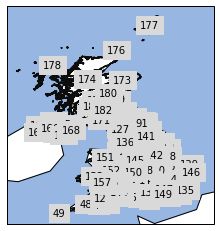

In [9]:
UK_regions.plot()

#### subselect UK data from global data

In [10]:
# Problem: 360/0 lon boundary

In [11]:
UK_regions.bounds_global

[-8.650007246402009, 49.8823405149758, 1.76357118981522, 60.85644221099626]

In [12]:
shift=360
pad=2 # extra lon lat to select
print('lon:',UK_regions.bounds_global[0]+shift,UK_regions.bounds_global[2]+shift)
precip_UK = precip.sel(lon=slice(UK_regions.bounds_global[0]+shift-pad,UK_regions.bounds_global[2]+shift+pad),
                      lat=slice(UK_regions.bounds_global[1]-pad,UK_regions.bounds_global[3]+pad))
precip_UK.coords,precip_UK.shape,precip_UK.dims

lon: 351.349992753598 361.7635711898152


(Coordinates:
     forecast_period          timedelta64[ns] 02:00:00
   * lat                      (lat) float32 47.953125 48.046875 ... 62.765625
   * lon                      (lon) float32 349.3828 349.52344 ... 359.9297
     forecast_reference_time  (time) datetime64[ns] 2020-01-01T09:00:00 2020-01-02T09:00:00
   * time                     (time) datetime64[ns] 2020-01-01T11:00:00 2020-01-02T11:00:00,
 (2, 159, 76),
 ('time', 'lat', 'lon'))

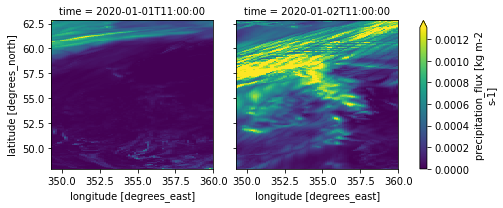

In [13]:
precip_UK.plot(col='time',robust=True)

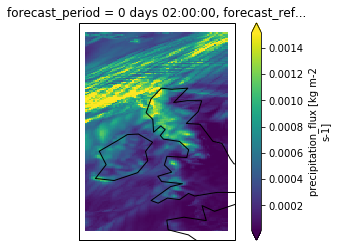

In [14]:
proj=ccrs.PlateCarree()
ax = plt.axes(projection=proj)
precip_UK.isel(time=1).plot(y="lat", x="lon", ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.coastlines()

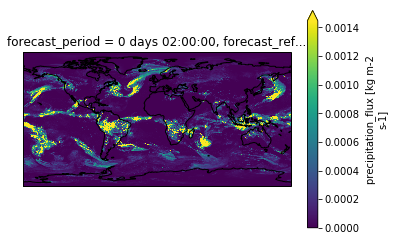

In [15]:
ax = plt.axes(projection=ccrs.PlateCarree())
precip.isel(time=0).plot(y="lat", x="lon", ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.set_global()
ax.coastlines()

# 3. Subsample into regions

In [16]:
# without subselecting UK, i.e. when using global data
# CPU times: user 2min 17s, sys: 1.04 s, total: 2min 18s
# Wall time: 2min 20s

# after subselecting UK only, but doesnt really select it correctly yet
# CPU times: user 68 ms, sys: 8.76 ms, total: 76.8 ms
# Wall time: 77.5 ms

In [ ]:
# https://regionmask.readthedocs.io/en/stable/notebooks/mask_xarray.html#select-using-groupby
# mask regions
%time uk_regions_masked = UK_regions.mask(precip)

In [ ]:
uk_regions_masked.plot()

In [ ]:
# groupby masked regions
%time precip_regions = precip.groupby(uk_regions_masked).mean('stacked_lat_lon')

In [ ]:
def set_labels(ds,region):
    abbrevs = region[ds.region.values].abbrevs
    names = region[ds.region.values].names

    ds.coords['abbrevs'] = ('region', abbrevs)
    ds.coords['names'] = ('region', names)
    return ds

In [ ]:
precip_regions = set_labels(precip_regions,UK_regions)

In [ ]:
precip_regions.plot(hue='region',add_legend=False)
plt.show()

# 4. Save to csv

In [ ]:
drop=['forecast_period','forecast_reference_time']
df = precip_regions.drop(drop).to_dataframe()
df

In [ ]:
df.to_csv('regions.csv')

# 5. Example 2: World

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [ ]:
world.head()

In [316]:
%time world_region = regionmask.from_geopandas(world,names='name')

CPU times: user 13.1 ms, sys: 1.93 ms, total: 15 ms
Wall time: 15.9 ms


In [317]:
def regionmask_region_to_xr_regions(ds,region):
    # mask regions
    regions_masked = region.mask(ds)
    # groupby masked regions
    ds_regions = ds.groupby(regions_masked).mean('stacked_lat_lon')
    ds_regions = set_labels(ds_regions,region)
    ds_regions['region']=ds_regions.names
    return

In [ ]:
%time precip_world_regions = regionmask_region_to_xr_regions(precip, world_region)

In [ ]:
precip_world_regions.plot(hue='region')
plt.show()